This is a very easy example of the regression ad hoc analysis. In this case the data demonstrates linear relashinship. Having run OLS regression, the residuals meet all requarements (independence, homoskedasticity, normality).

More details: https://www.kaggle.com/datasets/abhishek14398/salary-dataset-simple-linear-regression

In [ ]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install statsmodels
%pip install scikit-learn

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import sys

In [3]:
# Reading the dataset
df = pd.read_csv(r"D:\z. Regressions\Salary_dataset.csv")
df.head(5)

,Unnamed: 0,YearsExperience,Salary
0,0,1.2,39344.0
1,1,1.4,46206.0
2,2,1.6,37732.0
3,3,2.1,43526.0
4,4,2.3,39892.0


In [4]:
# let's delete index
del df['Unnamed: 0']
df.head(5)

,YearsExperience,Salary
0,1.2,39344.0
1,1.4,46206.0
2,1.6,37732.0
3,2.1,43526.0
4,2.3,39892.0


In [5]:
#let's check the data

# Descriptive statistics
df.describe(include="all")

,YearsExperience,Salary
count,30.000000,30.000000
mean,5.413333,76004.000000
std,2.837888,27414.429785
min,1.200000,37732.000000
25%,3.300000,56721.750000
50%,4.800000,65238.000000
75%,7.800000,100545.750000
max,10.600000,122392.000000


No negative values!

In [6]:
# let's check doubles:
print(df.duplicated().sum())  # Count duplicate rows
print(df[df.duplicated(keep=False)])  # Show all duplicate rows

0
Empty DataFrame
Columns: [YearsExperience, Salary]
Index: []


No duplicates!

In [7]:
# Checking correct data type
df.dtypes

YearsExperience    float64
Salary             float64
dtype: object

In [8]:
# checking counts
df.info()
print(sys.getsizeof(df))
#print(df.memory_usage(deep=True))  # More detailed memory usage

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   YearsExperience  30 non-null     float64
 1   Salary           30 non-null     float64
dtypes: float64(2)
memory usage: 612.0 bytes
644


In [9]:
# let's optmize a bit so we use less memory and calculate faster.
df['YearsExperience']   = df['YearsExperience'].astype('float16') # value pattern: 1 or digid and one digit after decimal. float 8 would be enough but it is not supported
df['Salary']            = df['Salary'].astype('int32')
df.info()
print(sys.getsizeof(df))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   YearsExperience  30 non-null     float16
 1   Salary           30 non-null     int32  
dtypes: float16(1), int32(1)
memory usage: 312.0 bytes
344


So, we decreased memory usage from 612 bytes to 312 bytes - 2x times!

We done with Data Wrangling. Data is checked for duplicates(none), missing values(none), data types (we optimized datatypes to decrease memory usage). No negatives values for Salary and Experience. Data is ready for the next steps.

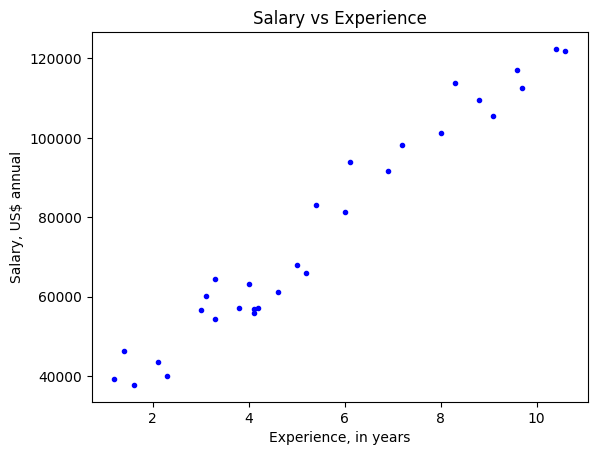

In [10]:
#let's have a look how YearsExperience is ralated to Salary

plt.scatter(df['YearsExperience'], df['Salary'], marker = '.', color='blue')
plt.title('Salary vs Experience')
plt.xlabel('Experience, in years')
plt.ylabel('Salary, US$ annual')
plt.show()


Visually, the relationship between Salary and Experience is linear. So, for this case linear regression should work very well. Althought it does not look necessary for this particual case, let's have a more detailed view on the data before runnig regressions.

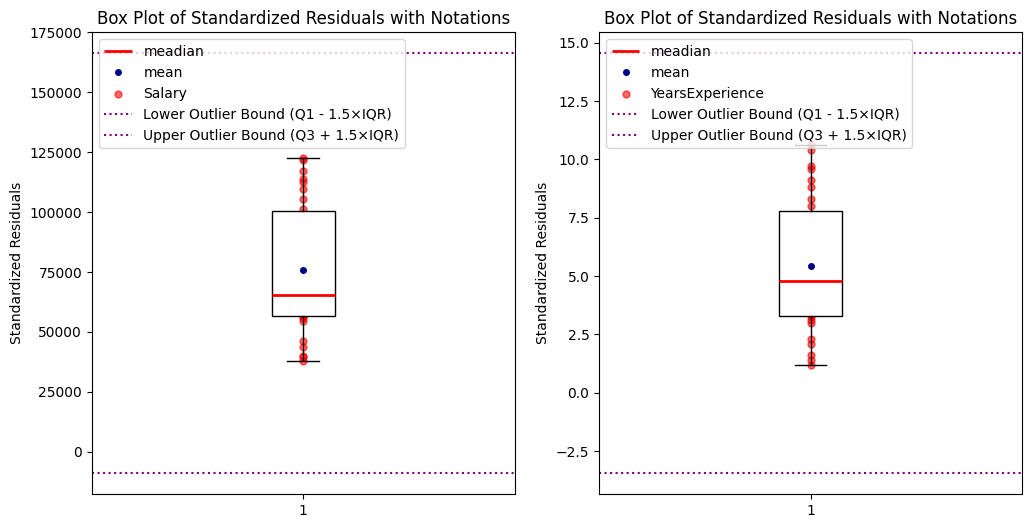

In [11]:
# Let's build boxplots to have a look at the outliers in the intial data
plt.figure(figsize=(12, 6))

variables = [df['Salary'], df['YearsExperience']]
counter=1
for variable in variables:
    plt.subplot(1,2, counter)
        
    # Compute key statistics for the box plot annotations
    Q1          = np.percentile(variable, 25)  # 25th percentile (First Quartile)
    Q3          = np.percentile(variable, 75)  # 75th percentile (Third Quartile)
    IQR         = Q3 - Q1  # Interquartile Range (IQR)

    # Bounds for outliers:
    lower_bound = Q1 - 1.5 * IQR  # Lower bound for outliers
    upper_bound = Q3 + 1.5 * IQR  # Upper bound for outliers

    # Create a boxplot for standardized residuals with proper labels
    plt.boxplot(variable, vert=True, patch_artist=True, 
                boxprops=dict(facecolor="white"),  # Box color
                medianprops=dict(color="red", linewidth=2, label='meadian'),  # Customize median
                showmeans=True,  # Show the mean
                meanprops=dict(marker="o", markerfacecolor='darkblue', markeredgecolor='darkblue', markersize=4, label='mean')
                )

    # Add individual points for the residuals
    plt.scatter(np.ones_like(variable), variable, alpha=0.6, color="red", label=variable.name, marker = "o", s=25)

    # Add annotations for key statistics
    plt.axhline(lower_bound, color="purple", linestyle=":", label="Lower Outlier Bound (Q1 - 1.5×IQR)")
    plt.axhline(upper_bound, color="purple", linestyle=":", label="Upper Outlier Bound (Q3 + 1.5×IQR)")

    # Labels and title
    plt.ylabel("Standardized Residuals")
    plt.title("Box Plot of Standardized Residuals with Notations")
    plt.legend(loc="upper right")
    plt.legend(loc="upper left")
    counter = counter + 1

# Show plot
plt.show()



The whiskers end with the last data points and are quite away from the calculated lower and upper bound thresholds. Meaning, no outliers in the datasets.  Salary has the  median lower than the mean, and upper whisker longer than the lower, meaning the distribition is not symmetrical and has right skewness.

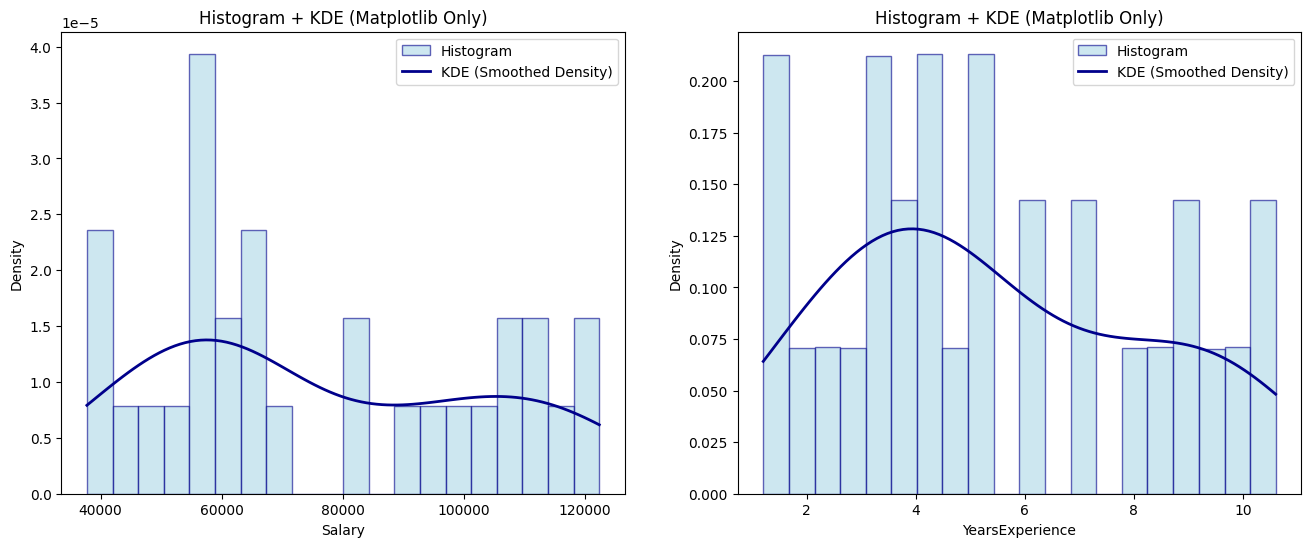

In [12]:
# Create a Histogram + KDE plot
plt.figure(figsize=(16, 6))

variables = [df['Salary'], df['YearsExperience']]
counter=1
for variable in variables:
    plt.subplot(1,2, counter)
    
    # Compute KDE
    kde = gaussian_kde(variable)  # Fit KDE model
    x_range = np.linspace(min(variable), max(variable), 100)  # Smooth x-axis values

    # Plot histogram
    plt.hist(variable, bins=20, color="lightblue", edgecolor="darkblue", alpha=0.6, density=True, label="Histogram")

    # Plot KDE curve
    plt.plot(x_range, kde(x_range), color="darkblue", linewidth=2, label="KDE (Smoothed Density)")

    # Labels and title
    plt.xlabel(variable.name)
    plt.ylabel("Density")
    plt.title("Histogram + KDE (Matplotlib Only)")
    plt.legend()
    counter = counter+1

# Show plot
plt.show()

Obviously, the distributions are not normal. However, the OLS does not require normality for the variables. It requires linear dependance (shown above) and absence of strong multicolliearity for multivariate regressions. We have only one independant variable for this requirement is not relevant.

It seems that are ready to run linear regression.

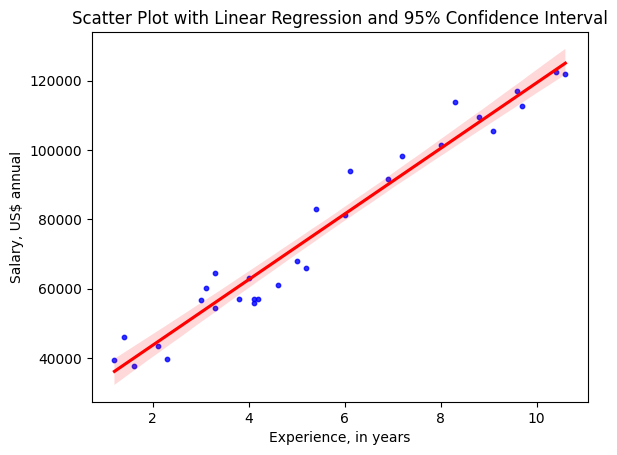

In [13]:
#Visualization of relationship between Salary and Experience w/ trend and CI.
# Scatter plot with regression line and confidence interval
x = df['YearsExperience']
y = df['Salary']
sns.regplot(x=x, y=y, data=df, ci=95, scatter_kws={"s": 10, "color": "blue"}, line_kws={"color": "red"})
plt.title('Salary vs Experience')
plt.xlabel('Experience, in years')
plt.ylabel('Salary, US$ annual')
plt.title("Scatter Plot with Linear Regression and 95% Confidence Interval")
plt.show()

In [14]:
# Let's run OLS regression

#defining variables:
X = df[['YearsExperience']] # it has to be 2D to add constant
X = sm.add_constant(X)      # Adding constant
Y = df['Salary']

#Running OLS regression
model_ols = sm.OLS(Y, X).fit()

# Print Summary of Regression Results
print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     621.4
Date:                Sun, 09 Mar 2025   Prob (F-statistic):           1.17e-20
Time:                        23:44:04   Log-Likelihood:                -301.47
No. Observations:                  30   AIC:                             606.9
Df Residuals:                      28   BIC:                             609.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2.485e+04   2308.630     

Everything looks quite well. No autcorrelation in residuals (DW), JB suggests the residuals distribution is close to normal. No strong multicollinearity.No fixes are needed. Anyway, let's have a look at QQplot, Cook's distance and other visualization of residuals.

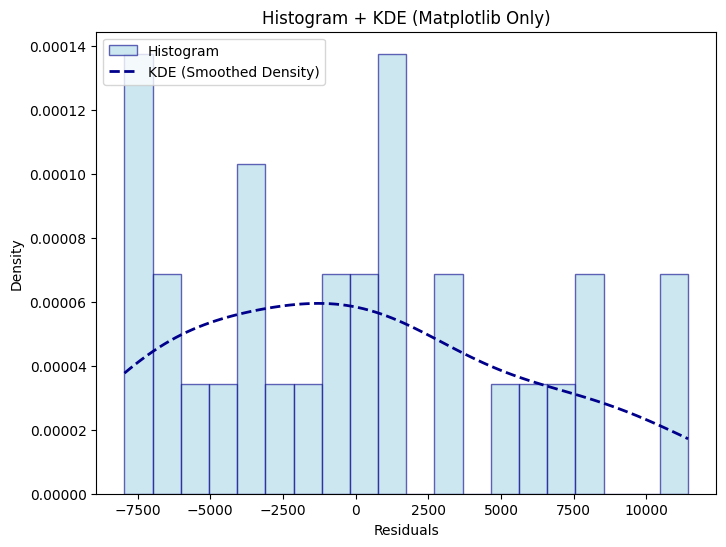

In [16]:
# Let's have a look at the residuals histogram

plt.figure(figsize=(8, 6))
residuals       = model_ols.resid 
#variable = residuals
 
# Compute KDE
kde = gaussian_kde(residuals)  # Fit KDE model
x_range = np.linspace(min(residuals), max(residuals), 100)  # Smooth x-axis values

# Plot histogram
plt.hist(residuals, bins=20, color="lightblue", edgecolor="darkblue", alpha=0.6, density=True, label="Histogram")

# Plot KDE curve
plt.plot(x_range, kde(x_range), color="darkblue", linewidth=2, linestyle = '--', label="KDE (Smoothed Density)")

# Labels and title
plt.xlabel("Residuals")
plt.ylabel("Density")
plt.title("Histogram + KDE (Matplotlib Only)")
plt.legend(loc="upper left")
   
# Show plot
plt.show()

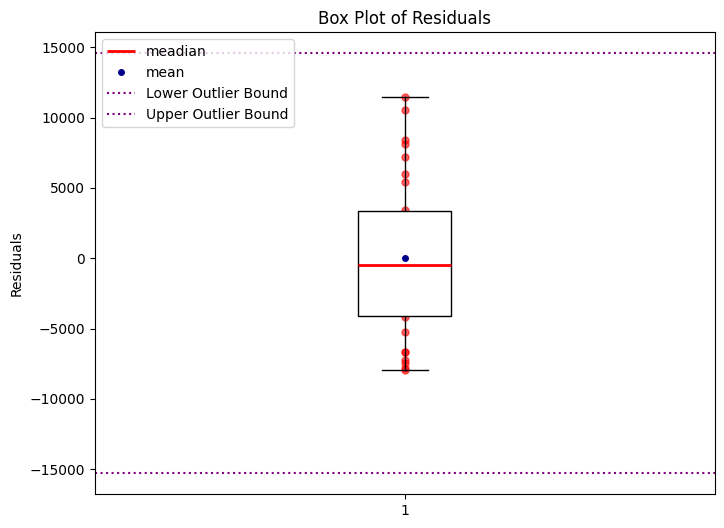

In [17]:
#Let's have a look at the outliers in the residulas and start from simple boxplot

plt.figure(figsize=(8, 6))

variable = residuals
       
# Compute key statistics for the box plot annotations
Q1          = np.percentile(variable, 25)  # 25th percentile (First Quartile)
Q3          = np.percentile(variable, 75)  # 75th percentile (Third Quartile)
IQR         = Q3 - Q1  # Interquartile Range (IQR)

# Bounds for outliers:
lower_bound = Q1 - 1.5 * IQR  # Lower bound for outliers
upper_bound = Q3 + 1.5 * IQR  # Upper bound for outliers

# Create a boxplot for standardized residuals with proper labels
plt.boxplot(variable, vert=True, patch_artist=True, 
            boxprops=dict(facecolor="white"),  # Box color
            medianprops=dict(color="red", linewidth=2, label='meadian'),  # Customize median
            showmeans=True,  # Show the mean
            meanprops=dict(marker="o", markerfacecolor='darkblue', markeredgecolor='darkblue', markersize=4, label='mean')
            )

# Add individual points for the residuals
plt.scatter(np.ones_like(variable), variable, alpha=0.6, color="red", label=variable.name, marker = "o", s=25)

# Add annotations for key statistics
plt.axhline(lower_bound, color="purple", linestyle=":", label="Lower Outlier Bound")
plt.axhline(upper_bound, color="purple", linestyle=":", label="Upper Outlier Bound")

# Labels and title
plt.ylabel("Residuals")
plt.title("Box Plot of Residuals")
plt.legend(loc="upper left")

# Show plot
plt.show()

The boxplot looks fine. The meadian and the mean are close to each other and to zero. One outlier.

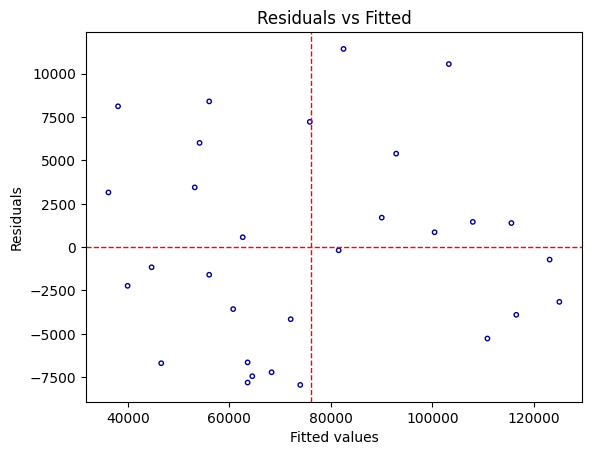

In [18]:
#Let's have a look at Residuals vs Fitted plot

Y_hat           = model_ols.fittedvalues
#residuals       = model.resid  #defined above

#let's have means for the mean lines (vertical and horizontal)
Y_hat_mean      = np.mean(Y_hat)
residuals_mean  = np.mean(residuals)

plt.scatter(Y_hat, residuals, marker="o", edgecolors="darkblue", facecolors="none", s=10)
plt.axhline(y=residuals_mean, color='red', linestyle='--', linewidth=1, label="Mean Residuals")  # Horizontal
plt.axvline(x=Y_hat_mean, color='red', linestyle='--', linewidth=1, label="Mean Fitted")  # Vertical
plt.title("Residuals vs Fitted")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

No patterns in Residual_fitted plot. Assuming independance in residuals.

c:\Users\Andrey Kobelev\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


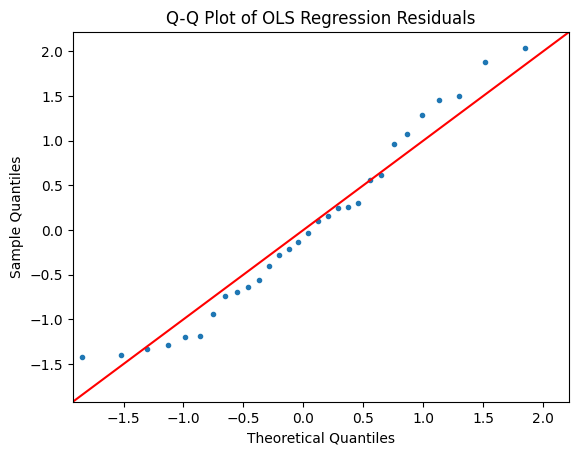

In [19]:
# let's start w/ QQplot

# Create the Q-Q Plot
sm.qqplot(residuals, line='45',marker = '.', color = 'darkblue', fit=True)
plt.title("Q-Q Plot of OLS Regression Residuals")
plt.show()

The residuals distribtion is very close to the normal.

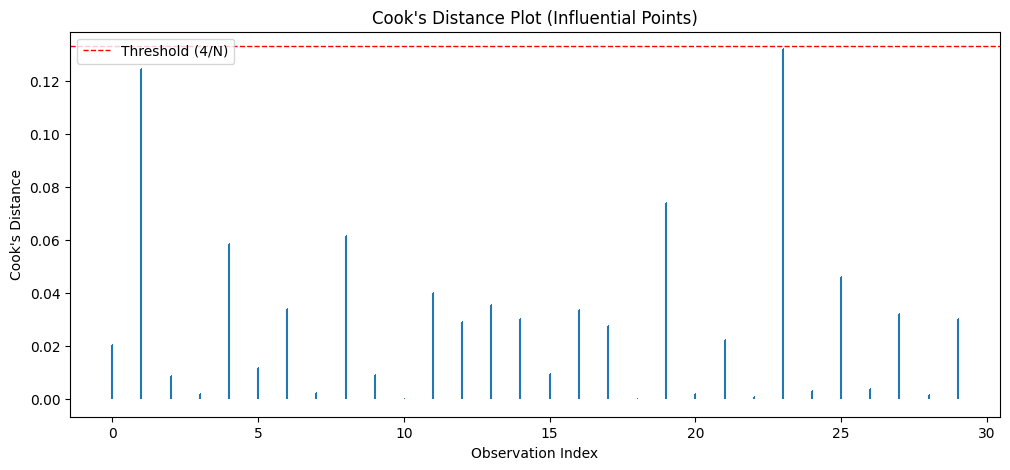

In [20]:
# Compute Cook's Distance
influence = model_ols.get_influence()
cooks_d, _ = influence.cooks_distance  # Cook's Distance values

# Plot Cook's Distance with Vertical Lines
plt.figure(figsize=(12, 5))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",", basefmt=" ")  # Vertical lines

# Add Threshold Line (Conservative Threshold: 4/N)
n = len(cooks_d)
threshold = 4 / n  # Conservative threshold for Cook's Distance
plt.axhline(y=threshold, color="red", linestyle="--", linewidth=1, label="Threshold (4/N)")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance Plot (Influential Points)")
plt.legend(loc="upper left")
plt.show()

Cook's distance plot shows that there are no influencial outliers

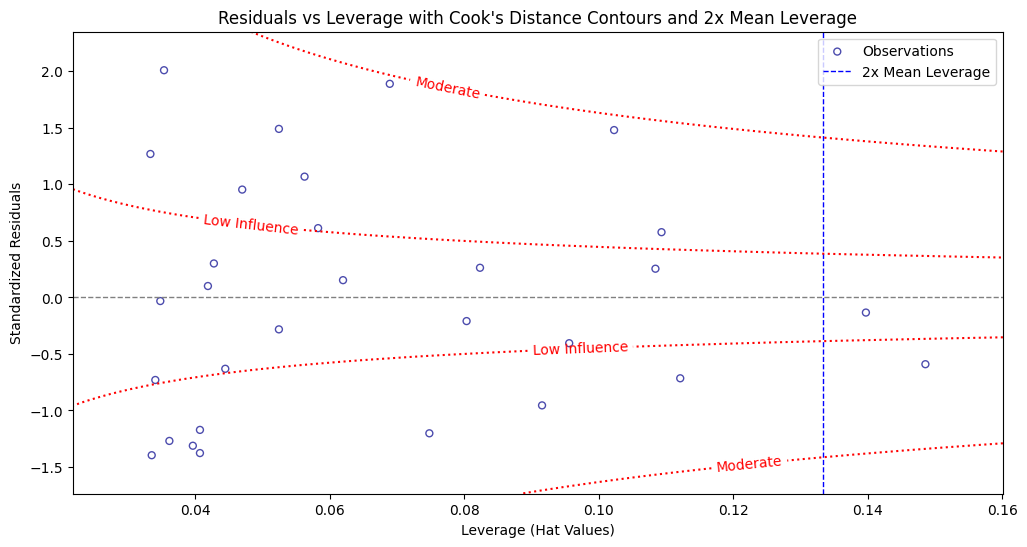

In [21]:

# Get influence measures
influence               = model_ols.get_influence()
leverage                = influence.hat_matrix_diag  # Leverage values
standardized_residuals  = influence.resid_studentized_internal  # Standardized residuals
cooks_d                 = influence.cooks_distance[0]  # Cook’s Distance values

# Compute mean leverage and 2x mean leverage threshold
mean_leverage       = np.mean(leverage)
threshold_leverage  = 2 * mean_leverage

# Create figure
plt.figure(figsize=(12, 6))

# Scatter plot of leverage vs standardized residuals (Hollow circles)
plt.scatter(leverage, standardized_residuals, alpha=0.7, marker="o",
            edgecolors="darkblue", facecolors="none", s=25, label="Observations")

# Add reference lines
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)  # Horizontal reference line at residual=0
plt.axvline(x=threshold_leverage, color='blue', linestyle='--', linewidth=1, label="2x Mean Leverage")  # High leverage threshold

# Expand axis limits to fit all circles and Cook’s Distance contours properly
buffer_x = (max(leverage) - min(leverage)) * 0.1  # 10% padding for x-axis
buffer_y = (max(standardized_residuals) - min(standardized_residuals)) * 0.1  # 10% padding for y-axis
x_min, x_max = min(leverage) - buffer_x, max(leverage) + buffer_x
y_min, y_max = min(standardized_residuals) - buffer_y, max(standardized_residuals) + buffer_y

plt.xlim(x_min, x_max)  # Expand x-axis
plt.ylim(y_min, y_max)  # Expand y-axis

# Create an extended grid for contouring Cook's Distance to match new axis limits
lev_range = np.linspace(x_min, x_max, 100)
res_range = np.linspace(y_min, y_max, 100)
lev_grid, res_grid = np.meshgrid(lev_range, res_range)

# Compute Cook's Distance on grid points
cooks_grid = (lev_grid * res_grid**2) / (2 * model_ols.df_model)

# Define meaningful Cook’s Distance levels (Avoid 0.00)
min_cook_level = max(0.01, min(cooks_d))  # Ensure the smallest level is meaningful
cooks_levels = np.sort([min_cook_level, 0.5, 1.0, 4.0 / len(X)])  # Moderate, Strong, Influential

# Add Cook’s Distance contours (curved red dotted lines)
contour = plt.contour(lev_grid, res_grid, cooks_grid, levels=cooks_levels, colors='red', linestyles='dotted')

# Label contours with meaningful names
fmt_labels = {
    cooks_levels[0]: "Low Influence", 
    cooks_levels[1]: "Moderate", 
    cooks_levels[2]: "Strong", 
    cooks_levels[3]: "Influential"
}
plt.clabel(contour, inline=True, fontsize=10, fmt=fmt_labels)  # Label contours

# Labels and title
plt.xlabel("Leverage (Hat Values)")
plt.ylabel("Standardized Residuals")
plt.title("Residuals vs Leverage with Cook's Distance Contours and 2x Mean Leverage")
plt.legend(loc='upper right')

# Show plot
plt.show()


There are 1 or 2 outliers at 2x mean leverage (blue line). However, according to the Cook's distances (red dotted lines) they are NOT influential. So we do not need to correct data.

OLS has few requirements for the residuals (it affects t test, F test, p_val, CI)
1. error terms should be independent (no auctocorrelations):<br>
Independence of error terms: looking at Residuals vs Fitted plot, Durbin-Watson:1.647 we can conculde that error terms are free of autocorrelations or any visible pattern. DW=1.64 is a kind of close to 1.5 threshold for positive autocorellation but still above it. also it is not timeseries.

2. Homoskedasticity:<br>
Homoskedasitcity. on Residuals vs Fitted plot it looks like the residuals distibution is homoskedastic, but perhaps to formally confirm it we have to run White or Breusch-Pagan tests (one more thing to do).

3. Normality:<br>
Normality. QQPlot and  Prob(Jarque-Bera (JB))= 0.456 and Prob (Omnibus) = 0.341 - both >0.05 confirm that residuals distribution is quite close to the normal.  Skewness is close to zero (where i ideally should be). Kurtosis is a bit away from 3 and equal to 2.144. ANyway Skew and Kurtosis are reasonably close to normal expectations.


In [25]:
# as per above, we still need to normally confirm homoskedasticity in the error term.

import statsmodels.stats.diagnostic as smd

# Run test
bp_test = smd.het_breuschpagan(model_ols.resid, model_ols.model.exog)
print(f'BP test statistic: {bp_test[0]}, p-value: {bp_test[1]}')

BP test statistic: 0.39038566327351365, p-value: 0.5320967504282743


Breusch-Pagan test has p_val much above 0.05 meaning that we cannot reject H0: Homoskedasticity holds

In [23]:
# let's run White test. it is better than Breusch -Pagan
white_test = smd.het_white(model_ols.resid, model_ols.model.exog)
print(f'White test statistic: {white_test[0]}, p-value: {white_test[1]}')

White test statistic: 3.298083531265558, p-value: 0.19223402564295708


White's test also confirms that the error term is homoskedastic. 

### Now, we have confirmed that all assumptions of OLS model for the error terms hold and can start interpretation of the results.

### Results:

R^2 = 0.957, meaning that 96% of variability in independant variable was explained by this regression. Excellent result!
F_stat, prob(F_stat) sugget that the model is highly significant. slope coefficint of experience is quite away from zero!

Const = 24,850 means that if an employee without zero years of experience enters to the market, he/she can expect to get annual salary of $25k
Slope coefficient = 9,449.86 means that every year of experience adds $10k to annual salary.

P-val for Const and slope coefficent are extremely low suggesting that the estimated parameters are statistically different from zeros.
Years of experience is a very strong predictor of salary. The relationship is statistically significant.

As a side exercise, let's split data set into learn and predict part to test how OLS univariate model work for prediciting the salaries.

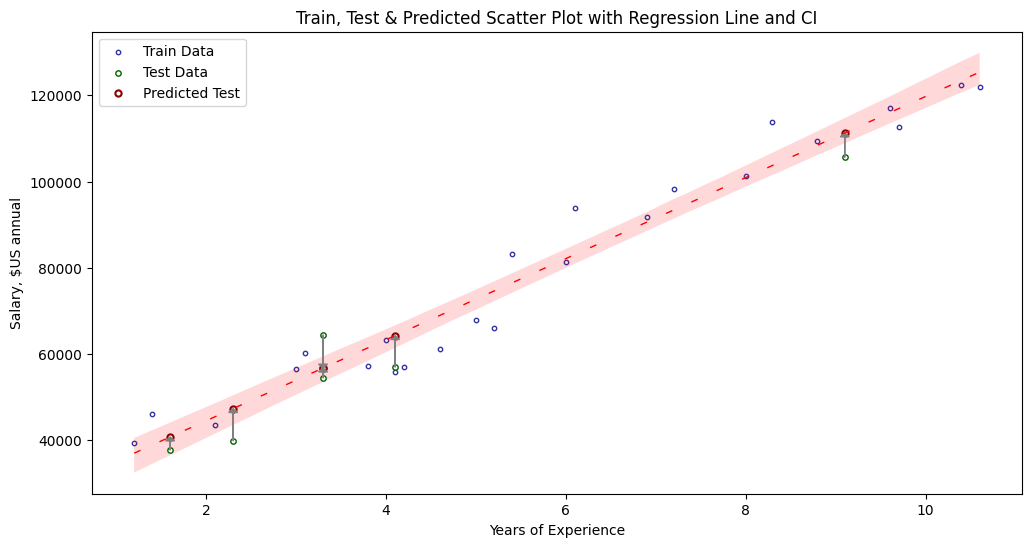

In [24]:
# Split dataset into train and test

#defining variables:
df_Const = sm.add_constant(df)      # Adding constant

train, test = train_test_split(df_Const, test_size=0.2, random_state=None) # random_state=42 serves as a seed to pseudo-random function. fixing it at any number, fixes the randomness. Want to have "full" (every time different) - have None instead

# Train the model on TRAIN set only
x_train = train[['const', 'YearsExperience']]
y_train = train['Salary']
model = sm.OLS(y_train, x_train).fit()

# Predict on test set
x_test = test[['const', 'YearsExperience']]
y_test = test['Salary']
y_pred = model.predict(x_test)

# Seaborn Regression Line (Train Data Only) with Confidence Interval
plt.figure(figsize=(12,6))

# Plot Train Data (Blue)
sns.regplot(
    x=x_train['YearsExperience'], 
    y=y_train, data=df, 
    ci=95, 
    scatter_kws={'edgecolors':'darkblue', 'facecolors':'white', 'linewidths':1, "s": 10},
    line_kws={"color": "red",'linestyle': (0, (5, 15)), 'linewidth': 1}, 
    label="Train Data"
    )

# Plot Test Data (Green)
sns.scatterplot(x=x_test['YearsExperience'], y=y_test, marker='o', edgecolors="darkgreen", facecolors="white", s=15, linewidth=1, label="Test Data")

# Plot Predicted Test Points (White with Red Rings)
sns.scatterplot(x=x_test['YearsExperience'], y=y_pred, marker='o', edgecolors="darkred", facecolors="white", s=20, linewidth=1.5, label="Predicted Test")

# Add Arrows from actual test points (Green) to predicted points (Red Rings)
arrow_length = 900 #axis Y is like 120000
for i in range(len(test)):
    plt.arrow(x_test['YearsExperience'].iloc[i], y_test.iloc[i], 
              0, y_pred.iloc[i] - y_test.iloc[i] - arrow_length*np.sign(y_pred.iloc[i] - y_test.iloc[i]), 
              color="grey", linewidth=1, head_width=0.1, head_length=arrow_length, alpha=1)

# Labels & Legend
plt.xlabel("Years of Experience")
plt.ylabel("Salary, $US annual")
plt.title("Train, Test & Predicted Scatter Plot with Regression Line and CI")
plt.legend()

plt.show()